In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from sklearn.linear_model import LogisticRegression
from time import perf_counter

#import sys
#np.set_printoptions(threshold=sys.maxsize)

In [2]:
np.random.seed(13)

In [3]:
def evolve(p):
    N = p.shape[0]
    seq = np.random.rand(N)
    seq = 2*(seq<p)-1
    return seq

def generate_data(h,J,L):
    N = h.shape[0]
    s = np.zeros((L,N))
    s[0,:] = np.random.choice([1.0, -1.0],N,replace=True)
    for l in range(L-1):
        H = h+np.dot(J,s[l,:]) # Jij from j to i
        p = 1/(1+np.exp(-2*H))
        s[l+1,:]= evolve(p)
    return s

In [4]:
N = 80 # system size
L = 8000 # length of trajectory
g_h = 0.1 # scale of external biases (h)
g_J = 1.0 # scale of internal couplings (J)

h_true = np.random.normal(0.0,g_h,size=N)
J_true = np.random.normal(0.0,g_J/np.sqrt(N),size=(N,N))

s_true = generate_data(h_true,J_true,L)

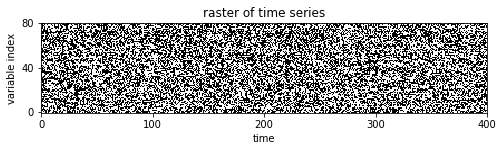

In [5]:
plt.figure(figsize=(8,3))
plt.title('raster of time series')
plt.imshow(s_true.T[:,:400],cmap='gray',origin='lower')
plt.xticks([0,100,200,300,400])
plt.yticks([0,40,80])
plt.xlabel('time')
plt.ylabel('variable index')
plt.show()

In [6]:
# fitting by logistic regression
def LR(s,bias=True):
    # s: spin history (L*N)
    # bias: True when the external bias is considered
    
    L, N = np.shape(s)
    
    logistic = LogisticRegression(solver = 'lbfgs', tol=1e-6, max_iter=10000000, fit_intercept=bias, C=100)
    # C: the scale of regularization (low C -> strong regularization)
    
    h = np.zeros(N)
    J = np.zeros((N,N))
    
    for i in range(N):
        
        si = (s[1:,i]+1)/2
        si = si.astype(np.int8)
        
        logistic.fit(s[:-1,:], si)
        
        J[i,:] = logistic.coef_/2
        if bias==True:
            h[i] = logistic.intercept_/2
            
    return h, J

In [7]:
# fitting by free energy minimization (expectation reflection)
def fem(s,bias=True):
    
    L, N = s.shape
    m = np.mean(s[:-1,:],axis=0)
    ds = s[:-1,:] - m
    ds = ds.T
    L1 = L-1

    c = np.cov(ds,bias=True)
    c_inv = np.linalg.inv(c)

    h = np.zeros(N)
    J = np.zeros((N,N))
    
    tol = 1e-8
    nloop = 10000
    
    for i in range(N):
        
        s_i = s[1:,i]
        H_i = s_i.copy()
        cost = 100
        
        for iloop in range(nloop):
            H_i_av = np.mean(H_i)
            Hs_av = np.dot(ds,H_i-H_i_av)/L1
            J_i = np.dot(Hs_av,c_inv)
            if bias==True:
                h_i = H_i_av-np.dot(J_i,m)
                H_i = np.dot(s[:-1,:],J_i)+h_i
            else:
                h_i = 0
                H_i = np.dot(s[:-1,:],J_i)+h_i
            
            s_i_model = np.tanh(H_i)
            newcost = np.mean((s_i[:]-s_i_model[:])**2)
                        
            if cost-newcost<=tol: break
            cost = newcost
                       
            H_i *= np.divide(s_i,s_i_model,out=np.ones_like(s_i),where=s_i_model!=0)
            
            J[i,:] = J_i
            h[i] = h_i
        
    return h, J

In [8]:
# fitting with complete data
start = perf_counter()
h_lr, J_lr = LR(s_true,bias=True)
time = perf_counter() - start
print('time:',round(time,2),'s')

time: 1.89 s


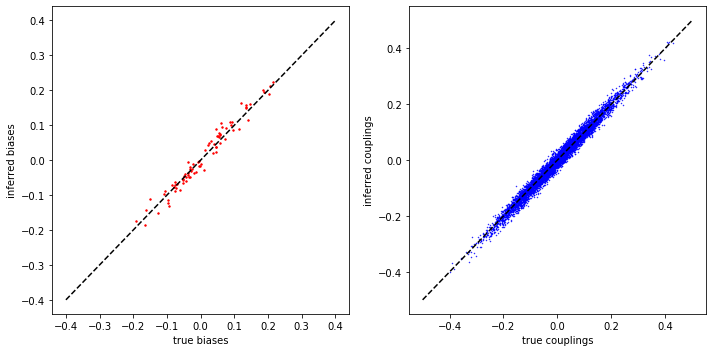

In [9]:
plt.figure(figsize=(10, 5))

ax0 = plt.subplot(1,2,1)
ax0.plot([-0.4,0.4],[-0.4,0.4],'k--')
ax0.scatter(np.reshape(h_true,(-1,1)),np.reshape(h_lr,(-1,1)),c='r',s=2)
ax0.set_xlabel('true biases')
ax0.set_ylabel('inferred biases')

ax1 = plt.subplot(1,2,2)
ax1.plot([-0.5,0.5],[-0.5,0.5],'k--')
ax1.scatter(np.reshape(J_true,(-1,1)),np.reshape(J_lr,(-1,1)),c='b',s=0.2)
ax1.set_xlabel('true couplings')
ax1.set_ylabel('inferred couplings')

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.show()

In [10]:
# RMSE: root mean square error
RMSE_h = np.sqrt(np.mean((h_true-h_lr)**2))
RMSE_J = np.sqrt(np.mean((J_true-J_lr)**2))
print('RMSE_h:',round(RMSE_h,6))
print('RMSE_J:',round(RMSE_J,6))

# cost: \sum_{i,t} (\sigma_i (t) - \langle \sigma_i (t) \rangle)^2
H = h_lr + np.dot(s_true[:-1,:],J_lr.T)
cost = np.mean((s_true[1:,:] - np.tanh(H))**2)
print('cost:',round(cost,6))

RMSE_h: 0.018876
RMSE_J: 0.015983
cost: 0.595453


In [11]:
# masking data

p = 0.5 # a fraction of missing data
obs_site = np.zeros((L,N)) # observed data points
for t in range(L):
    for i in range(N):
        if np.random.rand() < 1-p:
            obs_site[t,i] = 1
s_miss = s_true.copy() # the masked data
s_miss = s_miss*obs_site

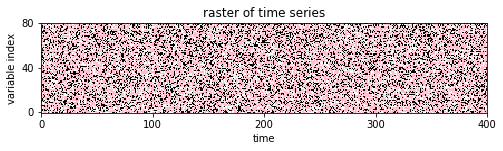

In [12]:
import matplotlib as mpl

masked_array = np.ma.masked_where(s_miss==0,s_miss)
cmap = mpl.cm.gray
cmap.set_bad(color='pink') # pink: missing data points

plt.figure(figsize=(8,3))
plt.title('raster of time series')
plt.imshow(masked_array.T[:,:400],cmap=cmap,origin='lower')
plt.xticks([0,100,200,300,400])
plt.yticks([0,40,80])
plt.xlabel('time')
plt.ylabel('variable index')
plt.show()

In [13]:
@jit(cache=True,nopython=True)
def update(s,obs_site,h,J,L,N):
    # update missing data points using likelihood ratios
    
    # t = 0
    iset = np.where(obs_site[0,:]==0)[0]
    if len(iset)!=0:
        np.random.shuffle(iset)
        for i in iset:
            p1 = 1/(1+np.exp(-2*h[i]))
            p2 = 1.0 - p1
            s[0,i] = 1
            H = h + np.dot(J,s[0,:])
            p1 = p1/np.prod(1+np.exp(-2*s[1,:]*H))
            p2 = p2/np.prod(1+np.exp(-2*s[1,:]*(H-2*J[:,i])))
            s[0,i] = (np.random.rand()<p1/(p1+p2))*2-1
    
    # t = L-1
    iset = np.where(obs_site[L-1,:]==0)[0]
    if len(iset)!=0:
        H = h + np.dot(J,s[L-2,:])
        p11 = 1/(1+np.exp(-2*H))
        for i in iset:
            s[L-1,i] = (np.random.rand()<p11[i])*2-1

    # 1<=t<=L-1
    tset = np.arange(1,L-1)
    np.random.shuffle(tset)
    for t in tset:
        iset = np.where(obs_site[t,:]==0)[0]
        if len(iset)==0:
            continue
        
        H = h + np.dot(J,s[t-1,:])
        p11 = 1/(1+np.exp(-2*H))
        p22 = 1-p11
        np.random.shuffle(iset)
        for i in iset:
            s[t,i] = 1.0
            H = np.dot(J,s[t,:])+h
            p1 = p11[i]/np.prod(1+np.exp(-2*s[t+1,:]*H))
            p2 = p22[i]/np.prod(1+np.exp(-2*s[t+1,:]*(H-2*J[:,i])))
            s[t,i] = (np.random.rand()<p1/(p1+p2))*2-1

In [14]:
def cal_cost(s,obs_site,h,J,L,N):
    # calculate cost functions for observed and missing data points
    
    H = h + np.dot(s[:-1,:],J.T)
    cost = (s[1:,:] - np.tanh(H))**2
    
    L_obs = np.sum(obs_site[1:,:])
    cost_obs = np.sum(obs_site[1:,:]*cost)
    L_mis = (L-1)*N-L_obs
    cost_mis = np.sum(cost)-np.sum(cost_obs)
    
    return cost_obs/L_obs, cost_mis/L_mis

In [15]:
def restore(s_miss,obs_site,bias=True,method='LR'):
    # infer both missing data points and parameters of kinetic Ising model
    
    s = s_miss.copy()
    L, N = s.shape
    
    nstep = 200
    eps = 0.01
    
    # initialize missing data points
    for t in range(L):
        for i in range(N):
            if obs_site[t,i]==0:
                s[t,i] = (np.random.rand()<0.5)*2-1
                
    if method=='LR':
        fit = LR
    elif method=='fem':
        fit = fem
    else:
        print('please enter appropriate method')
        return
    
    # initialize h and J
    h, J = fit(s,bias=bias)
    
    for step in range(nstep):
        
        # update missing data points (M-step)
        update(s,obs_site,h,J,L,N)
        
        # update h and J (E-step)
        h, J = fit(s,bias=bias)
        
        # calculate RMSE and cost functions 
        cost_obs, cost_mis = cal_cost(s,obs_site,h,J,L,N)
        RMSE_h = np.sqrt(np.mean((h-h_true)**2))
        RMSE_J = np.sqrt(np.mean((J-J_true)**2))
        
        print(step+1,round(RMSE_h,6),round(RMSE_J,6),round(cost_obs,6),round(cost_mis,6))
        
        if cost_mis-cost_obs<=eps:
            break
        
    return h, J, s, (cost_obs+cost_mis)/2

In [16]:
# fitting with incomplete data
start = perf_counter()
h_restored, J_restored, s_restored, cost = restore(s_miss,obs_site,bias=True)
time = perf_counter() - start
print('time:',round(time,2),'s')

1 0.051835 0.080678 0.829691 0.961862
2 0.041106 0.068151 0.765085 0.888784
3 0.036566 0.05829 0.719404 0.824572
4 0.032023 0.050159 0.686519 0.766346
5 0.030921 0.04411 0.660001 0.72131
6 0.030717 0.039837 0.641658 0.68509
7 0.030676 0.037392 0.627649 0.65991
8 0.031085 0.035917 0.617817 0.640237
9 0.031514 0.035369 0.609083 0.624294
10 0.031666 0.035295 0.602056 0.611861
time: 35.59 s


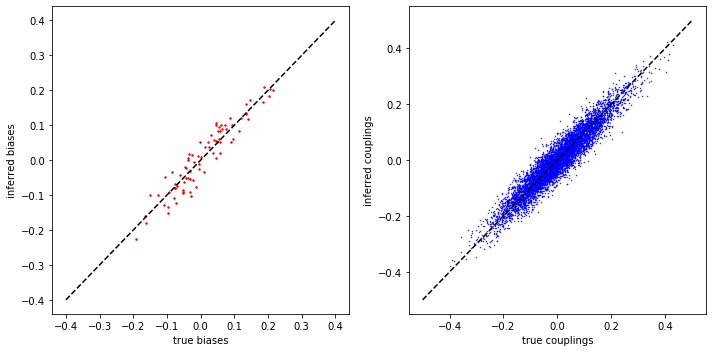

In [17]:
plt.figure(figsize=(10, 5))

ax0 = plt.subplot(1,2,1)
ax0.plot([-0.4,0.4],[-0.4,0.4],'k--')
ax0.scatter(np.reshape(h_true,(-1,1)),np.reshape(h_restored,(-1,1)),c='r',s=2)
ax0.set_xlabel('true biases')
ax0.set_ylabel('inferred biases')

ax1 = plt.subplot(1,2,2)
ax1.plot([-0.5,0.5],[-0.5,0.5],'k--')
ax1.scatter(np.reshape(J_true,(-1,1)),np.reshape(J_restored,(-1,1)),c='b',s=0.2)
ax1.set_xlabel('true couplings')
ax1.set_ylabel('inferred couplings')

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.show()

In [18]:
RMSE_h = np.sqrt(np.mean((h_true-h_restored)**2))
RMSE_J = np.sqrt(np.mean((J_true-J_restored)**2))
print('RMSE_h:',round(RMSE_h,6))
print('RMSE_J:',round(RMSE_J,6))

# reconstruction accuracy
accuracy = 1 - np.sum(((s_true-s_restored)*(1-obs_site))**2)/np.sum(1-obs_site)/4
print('accuracy:',round(accuracy,6))

RMSE_h: 0.031666
RMSE_J: 0.035295
accuracy: 0.695889


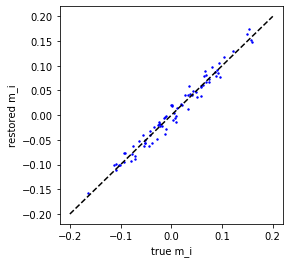

In [19]:
# mean activities
m = np.mean(s_true,axis=0)
m_restored = np.mean(s_restored,axis=0)

plt.figure(figsize=(4,4))
plt.scatter(m,m_restored,c='b',s=2)
plt.plot([-0.2,0.2],[-0.2,0.2],'k--')
plt.xlabel('true m_i')
plt.ylabel('restored m_i')
plt.show()

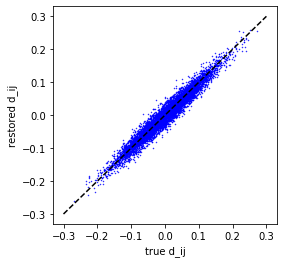

In [20]:
# one-step lagged correlation
d = np.dot((s_true[1:,:]-np.mean(s_true[1:,:],axis=0)).T,s_true[:-1,:]-np.mean(s_true[:-1,:],axis=0))/(L-1)
d_restored = np.dot((s_restored[1:,:]-np.mean(s_restored[1:,:],axis=0)).T,s_restored[:-1,:]-np.mean(s_restored[:-1,:],axis=0))/(L-1)

plt.figure(figsize=(4,4))
plt.scatter(np.reshape(d,(-1,1)),np.reshape(d_restored,(-1,1)),c='b',s=0.2)
plt.plot([-0.3,0.3],[-0.3,0.3],'k--')
plt.xlabel('true d_ij')
plt.ylabel('restored d_ij')
plt.show()

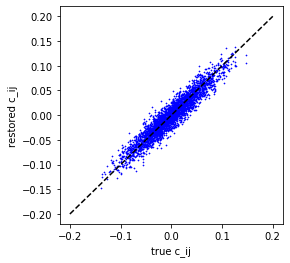

In [21]:
# equal-time correlation
c = np.dot((s_true-np.mean(s_true,axis=0)).T,s_true-np.mean(s_true,axis=0))/L
c_restored = np.dot((s_restored-np.mean(s_restored,axis=0)).T,s_restored-np.mean(s_restored,axis=0))/L
for i in range(N):
    c[i,i] = 0
    c_restored[i,i] = 0

plt.figure(figsize=(4,4))
plt.scatter(np.reshape(c,(-1,1)),np.reshape(c_restored,(-1,1)),c='b',s=0.2)
plt.plot([-0.2,0.2],[-0.2,0.2],'k--')
plt.xlabel('true c_ij')
plt.ylabel('restored c_ij')
plt.show()